### A Risk Problem
1. An agent’s utility of income exhibits constant relative risk aversion $\gamma>0$:

$$u(y) = \frac{y^{1-\gamma}}{1 - \gamma}$$

2. The agent faces uncertain income $\tilde y$ that is log-normally distributed with parameters $\mu$ and $\sigma^2$

3. The agent accepts a certain income $\bar y$ in place of his uncertain income $\tilde y$ provided that $$u(\bar y) \ge E[u(\tilde y)]$$

$$E[u(\tilde{y})] = \int_{0}^{\infty} f(\tilde{y})u(\tilde{y}) d\tilde{y}$$


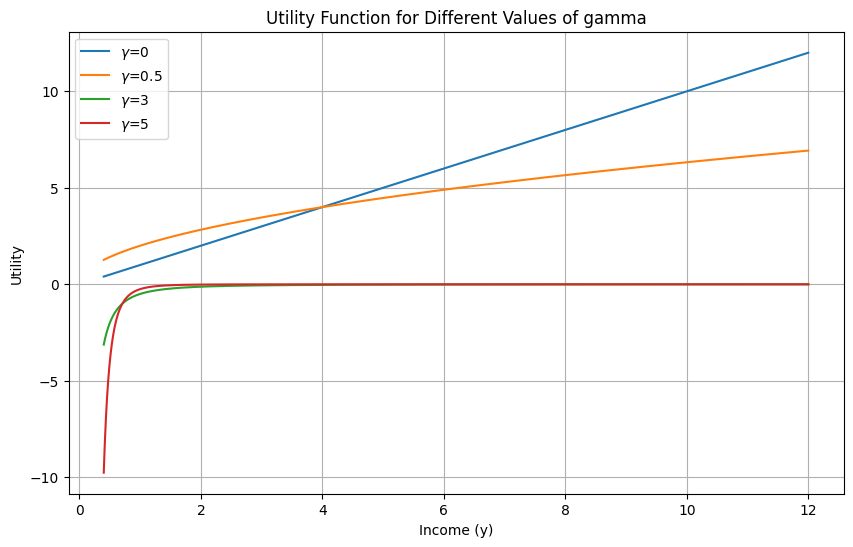

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import scipy.linalg as la
import math
from scipy.optimize import brentq
# Define the utility function
def utility(y, gamma):
    return (y**(1-gamma)) / (1 - gamma)
# Generate a range of income values
y_values = np.linspace(.4, 12, 10000)
# Values of gamma
gammas = [0, 0.5, 3, 5]
# Plot utility function for each value of gamma
plt.figure(figsize=(10, 6))
for gamma in gammas:
    plt.plot(y_values, utility(y_values, gamma), label=f'$\gamma$={gamma}')
plt.xlabel('Income (y)')
plt.ylabel('Utility')
plt.title('Utility Function for Different Values of gamma')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
from scipy.optimize import brentq
# Code to compute nodes:
def ckron(*arrays):
    # Repeatedly applies the np.kron function to an arbitrary number of input arrays
    return reduce(np.kron, arrays)
def gridmake(*arrays):
    if all([i.ndim == 1 for i in arrays]):
        d = len(arrays)
        if d == 2:
            out = _gridmake2(*arrays)
        else:
            out = _gridmake2(arrays[0], arrays[1])
            for arr in arrays[2:]:
                out = _gridmake2(out, arr)
        return out
    else:
        raise NotImplementedError("Come back here")
def _gridmake2(x1, x2):
    if x1.ndim == 1 and x2.ndim == 1:
        return np.column_stack([np.tile(x1, x2.shape[0]),
                                np.repeat(x2, x1.shape[0])])
    elif x1.ndim > 1 and x2.ndim == 1:
        first = np.tile(x1, (x2.shape[0], 1))
        second = np.repeat(x2, x1.shape[0])
        return np.column_stack([first, second])
    else:
        raise NotImplementedError("Come back here")        
def _qnwnorm1(n):
    maxit = 100
    pim4 = 1 / np.pi**(0.25)
    m = np.fix((n + 1) / 2).astype(int)
    nodes = np.zeros(n)
    weights = np.zeros(n)
    for i in range(m):
        if i == 0:
            z = np.sqrt(2*n+1) - 1.85575 * ((2 * n + 1)**(-1 / 6.1))
        elif i == 1:
            z = z - 1.14 * (n ** 0.426) / z
        elif i == 2:
            z = 1.86 * z + 0.86 * nodes[0]
        elif i == 3:
            z = 1.91 * z + 0.91 * nodes[1]
        else:
            z = 2 * z + nodes[i-2]
        its = 0
        while its < maxit:
            its += 1
            p1 = pim4
            p2 = 0
            for j in range(1, n+1):
                p3 = p2
                p2 = p1
                p1 = z * math.sqrt(2.0/j) * p2 - math.sqrt((j - 1.0) / j) * p3
            pp = math.sqrt(2 * n) * p2
            z1 = z
            z = z1 - p1/pp
            if abs(z - z1) < 1e-14:
                break
        if its == maxit:
            raise ValueError("Failed to converge in _qnwnorm1")
        nodes[n - 1 - i] = z
        nodes[i] = -z
        weights[i] = 2 / (pp*pp)
        weights[n - 1 - i] = weights[i]
    weights /= math.sqrt(math.pi)
    nodes = nodes * math.sqrt(2.0)
    return nodes, weights
def qnwnorm(n, mu=None, sig2=None, usesqrtm=False):
    n = np.asarray(n)
    d = n.size
    if mu is None:
        mu = np.zeros(d)
    else:
        mu = np.asarray(mu)
    if sig2 is None:
        sig2 = np.eye(d)
    else:
        sig2 = np.asarray(sig2).reshape(d, d)
    if all([x.size == 1 for x in [n, mu, sig2]]):
        nodes, weights = _qnwnorm1(n)
    else:
        nodes = []
        weights = []
        for i in range(d):
            _1d = _qnwnorm1(n[i])
            nodes.append(_1d[0])
            weights.append(_1d[1])
        nodes = gridmake(*nodes)
        weights = ckron(*weights[::-1])
    if usesqrtm:
        new_sig2 = la.sqrtm(sig2)
    else:  # cholesky
        new_sig2 = la.cholesky(sig2)
    if d > 1:
        nodes = nodes.dot(new_sig2) + mu  # Broadcast ok
    else:  # nodes.dot(sig) will not be aligned in scalar case.
        nodes = nodes * new_sig2 + mu
    return nodes.squeeze(), weights
def qnwlogn(n, mu=None, sig2=None):
    nodes, weights = qnwnorm(n, mu, sig2)
    return np.exp(nodes), weights

# Define the utility function
def utility(y, gamma):
    return (y**(1-gamma)) / (1 - gamma)
def expected_utility(gamma, y, w):
    #expected utility: U(Y) = Y^(1-gamma) / (1-gamma).
    return -w @ (y ** (1 - gamma)) / (1 - gamma)
def find_cev(y_guess, gamma, expected_utility):
    #Find the CEV such that U(y) = E[U(Ybar)] using Brent's method.
    # Define the objective function to find the root
    def objective_function(y):
        return - (y ** (1 - gamma)) / (1 - gamma) - expected_utility
    # Use Brent's method to find the root
    cev = brentq(objective_function, y_guess * 0.1, y_guess * 10)
    return cev
# Number of nodes
n = 100
# Parameters
mu = -0.5
var = 1
gamma = 3
y_guess = 0.1
# Compute the nodes and weights for lognormal distribution
y, w = qnwlogn(n, mu, var)
# Compute the expected utility
expected_utility_val = expected_utility(gamma, y, w)
print("The expected utility is:", expected_utility_val)
# Find the Certainty Equivalent Value (CEV)
cev = find_cev(y_guess, gamma, expected_utility_val)
print("The Certainty Equivalent Value (CEV) is:", cev)

The expected utility is: 10.042768461593798
The Certainty Equivalent Value (CEV) is: 0.22313016014843137


In [7]:
# Define parameter values for different cases
parameter_values = [
    {"gamma": 3, "mu": -0.5, "var": 2.0},
    {"gamma": 3, "mu": -0.25, "var": 1.0},
    {"gamma": 2, "mu": -0.5, "var": 1.0}]
# Compute certainty equivalent income for each case
results = []
for params in parameter_values:
    mu = params["mu"]
    var = params["var"]
    gamma = params["gamma"]
    y, w = qnwlogn(n, mu, var)
    expected_utility_val = expected_utility(gamma, y, w)
    cev = find_cev(y_guess, gamma, expected_utility_val)
    results.append({"gamma": gamma, "mu": mu, "var": var, "CEV": cev})
# Print results in a table format
print("Certainty Equivalent Income Results:")
print("{:<10} {:<10} {:<15} {:<20}".format("γ", "μ", "σ^2", "CEV"))
for result in results:
    print("{:<10} {:<10} {:<15} {:<20}".format(result["gamma"], result["mu"], result["var"], result["CEV"]))


Certainty Equivalent Income Results:
γ          μ          σ^2             CEV                 
3          -0.5       2.0             0.08208499862389802 
3          -0.25      1.0             0.2865047968601905  
2          -0.5       1.0             0.36787944117144544 
